<a href="https://colab.research.google.com/github/vuchicago/Python/blob/master/dogsandcatw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
####MOUNT DRIVE
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)


Mounted at /content/gdrive


In [0]:
####CREATE DIRECTORY NAMES AND DOWNLOAD VGG16 PRETRAINED NETWORK
import os, shutil
original_dataset_dir='/content/gdrive/My Drive/dogsandcats/train1'
original_dataset_test_dir='/content/gdrive/My Drive/dogsandcats/test'
base_dir= '/content/gdrive/My Drive/dogsandcats'

from keras.applications import VGG16

conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3)) ##download vgg16 code AND set it equal to conv_base
from matplotlib import pyplot as plt

train_dir=os.path.join(base_dir,'train')
validation_dir=os.path.join(base_dir,'validation')
test_dir=os.path.join(base_dir,'test')
train_cats_dir=os.path.join(train_dir,'cats')
train_dogs_dir=os.path.join(train_dir,'dogs')
validation_cats_dir=os.path.join(validation_dir,'cats')
validation_dogs_dir=os.path.join(validation_dir,'dogs')
test_cats_dir=os.path.join(test_dir,'cats')
test_dogs_dir=os.path.join(test_dir,'dogs')


In [0]:
####ONLY RUN THIS ONLY ONCE TO CREATE THE PROPER FOLDERS.  IGNORE IF FOLDERS ALREADY CREATED!!!

os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)
os.mkdir(train_cats_dir)
os.mkdir(train_dogs_dir)
os.mkdir(validation_cats_dir)
os.mkdir(validation_dogs_dir)
os.mkdir(test_cats_dir)
os.mkdir(test_dogs_dir)

In [0]:
##Copy cat and dog images to relevant directories created above
###RUN ONLY ONCE

fnames=['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src=os.path.join(original_dataset_dir,fname)
    dst=os.path.join(train_cats_dir,fname)
    shutil.copyfile(src,dst)
    
fnames=['cat.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src=os.path.join(original_dataset_dir,fname)
    dst=os.path.join(validation_cats_dir,fname)
    shutil.copyfile(src,dst)
    
fnames=['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src=os.path.join(original_dataset_dir,fname)
    dst=os.path.join(test_cats_dir,fname)
    shutil.copyfile(src,dst)
    
fnames=['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src=os.path.join(original_dataset_dir,fname)
    dst=os.path.join(train_dogs_dir,fname)
    shutil.copyfile(src,dst)
    
fnames=['dog.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src=os.path.join(original_dataset_dir,fname)
    dst=os.path.join(validation_dogs_dir,fname)
    shutil.copyfile(src,dst)
    
fnames=['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src=os.path.join(original_dataset_dir,fname)
    dst=os.path.join(test_dogs_dir,fname)
    shutil.copyfile(src,dst)

In [0]:
###SEE HOW MANY IMAGES ARE IN EACH FOLDER##########

print("total images in folder:",len(os.listdir(original_dataset_dir))) #4k images

print("total training cat images:",len(os.listdir(train_cats_dir))) #1k images

print("total training dog images:",len(os.listdir(train_dogs_dir))) #1k images

print("total val cat images:",len(os.listdir(validation_cats_dir))) #.5k images

print("total val dog images:",len(os.listdir(validation_dogs_dir))) #.5k images

print("total test cat images:",len(os.listdir(test_cats_dir))) #.5k images

print("total test dog images:",len(os.listdir(test_dogs_dir))) #.5k images

total images in folder: 4002
total training cat images: 1000
total training dog images: 1000
total val cat images: 500
total val dog images: 500
total test cat images: 500
total test dog images: 500


In [0]:
##########THIS WILL TRAIN THE INPUTS ON THE VGG16 AND USE ITS OUTPUTS AS INPUTS FOR THE REST OF THE MODEL######
#########YOU CAN USE DATA AUGMENTATION FOR THIS

from keras.applications import VGG16


import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

batch_size=20

#######################IMAGE AUGMENTATION TO CREATE NEW TRAINING EXAMPLES FROM EXISTING
#####DATA AUGMENT THE DATA page 139.  
datagen=ImageDataGenerator(rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=.2,
                           shear_range=.2,
                           zoom_range=.2,
                           horizontal_flip=True,
                           fill_mode='nearest')


def extract_features(directory,sample_count):
    features=np.zeros(shape=(sample_count,4,4,512)) ###create empty feature tensor
    labels=np.zeros(shape=(sample_count)) ##create empty label list
    generator=datagen.flow_from_directory(directory, target_size=(150,150),batch_size=batch_size,class_mode='binary') #create inputs and labels from directory
    
    i=0
    for inputs_batch,labels_batch in generator: 
        features_batch=conv_base.predict(inputs_batch)###PREDICT USING CONV_BASE FROM THE INPUT BATCH
        features[i*batch_size:(i+1)*batch_size]=features_batch #CREATE TENSOR OF FEATURES FROM BATCHES
        labels[i*batch_size:(i+1)*batch_size]=labels_batch 
        
        i+=1
        if i*batch_size>=sample_count:
            break #MUST BBREAK FROM GENERATED LOOP
    return features,labels

train_features,train_labels=extract_features(train_dir,2000)
validation_features,validation_labels=extract_features(validation_dir,1000)
test_features,test_labels=extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:

####CREATE THE ARCHITECTURE
train_features=np.reshape(train_features,(2000,4*4*512))
validation_features=np.reshape(validation_features,(1000,4*4*512))
test_features=np.reshape(test_features,(1000,4*4*512))


from keras import layers,models,optimizers
import time
model=models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=(4*4*512)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/100
2000/2000 [==============================] - 2s 897us/step - loss: 4.2043 - acc: 0.6210 - val_loss: 1.8808 - val_acc: 0.7640
Epoch 2/100
2000/2000 [==============================] - 1s 378us/step - loss: 2.7074 - acc: 0.7345 - val_loss: 1.4530 - val_acc: 0.8230
Epoch 3/100
2000/2000 [==============================] - 1s 382us/step - loss: 1.8576 - acc: 0.8010 - val_loss: 1.3340 - val_acc: 0.8370
Epoch 4/100
2000/2000 [==============================] - 1s 384us/step - loss: 1.6462 - acc: 0.8290 - val_loss: 1.2691 - val_acc: 0.8520
Epoch 5/100
2000/2000 [==============================] - 1s 387us/step - loss: 1.4713 - acc: 0.8445 - val_loss: 1.2252 - val_acc: 0.8590
Epoch 6/100
2000/2000 [==============================] - 1s 385us/step - loss: 1.2743 - acc: 0.8695 - val_loss: 1.2069 - val_acc: 0.8640
Epoch 7/100
2000/2000 [==============================] - 1s 389us/step - loss: 1.0

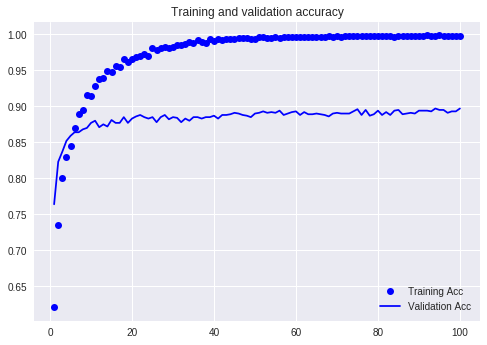

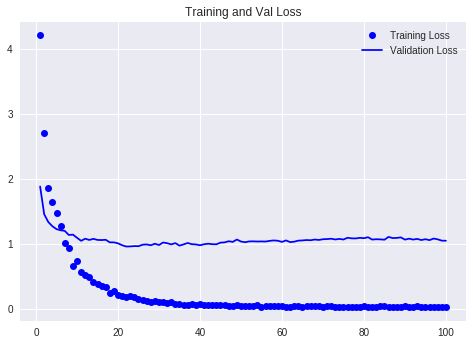

In [0]:

####THIS CODE RUNS WITH THE VGG16 ALREADY OUTPUTTING THE VALUES AND USING THOSE VALUES AS INPUTS FOR ARCHITECTURE ABOVE. 
###NOT AS GOOD AS CONVOLUTION UNFROZEN
import numpy as np
from matplotlib import pyplot as plt
start=time.time()

history=model.fit(train_features,train_labels,epochs=100,batch_size=20,validation_data=(validation_features,validation_labels))

end=time.time()
print('this takes ',np.subtract(end,start),"seconds to run")
##PLOT THE ACCURACY AND LOSS
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training Acc')
plt.plot(epochs,val_acc,'b',label="Validation Acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label="Training Loss")
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title("Training and Val Loss")
plt.legend()

plt.show()

In [0]:

model.save("catsanddogs_1.h5")

from google.colab import files
files.download("catsanddogs_1.h5")

In [0]:
#####THIS IS THE GENERATOR USED FOR THE NEXT TWO MODELS, ONE WITH CONV_BASE FROZEN AND THE OTHER WITHOUT IT FROZEN
from keras import layers,models,optimizers

from keras.preprocessing.image import ImageDataGenerator

model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

conv_base.trainable=False ###FREEZE THE VGG16 CONVOLUTIONAL BASE

train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=.2,
                           shear_range=.2,
                           zoom_range=.2,
                           horizontal_flip=True,
                           fill_mode='nearest')
test_datagen=ImageDataGenerator(rescale=1./255) ###Not using augmented data for testing


train_generator=train_datagen.flow_from_directory(train_dir,target_size=(150,150),batch_size=40,shuffle=True,class_mode='binary')
validation_generator=test_datagen.flow_from_directory(validation_dir,target_size=(150,150),batch_size=30,shuffle=True,class_mode='binary')
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:

print("This is the number of trainable weights:",len(model.trainable_weights))

This is the number of trainable weights: 4


Epoch 1/10
100/100 [==============================] - 44s 443ms/step - loss: 0.0416 - acc: 0.9897 - val_loss: 0.2460 - val_acc: 0.9400
Epoch 2/10
100/100 [==============================] - 40s 399ms/step - loss: 0.0094 - acc: 0.9973 - val_loss: 0.3033 - val_acc: 0.9390
Epoch 3/10
100/100 [==============================] - 40s 399ms/step - loss: 0.0053 - acc: 0.9977 - val_loss: 0.3134 - val_acc: 0.9380
Epoch 4/10
100/100 [==============================] - 40s 400ms/step - loss: 0.0078 - acc: 0.9980 - val_loss: 0.3759 - val_acc: 0.9390
Epoch 5/10
100/100 [==============================] - 40s 401ms/step - loss: 0.0038 - acc: 0.9987 - val_loss: 0.3369 - val_acc: 0.9390
Epoch 6/10
100/100 [==============================] - 40s 400ms/step - loss: 0.0049 - acc: 0.9983 - val_loss: 0.3763 - val_acc: 0.9410
Epoch 7/10
100/100 [==============================] - 40s 399ms/step - loss: 0.0069 - acc: 0.9977 - val_loss: 0.4287 - val_acc: 0.9410
Epoch 8/10
100/100 [==============================] - 4

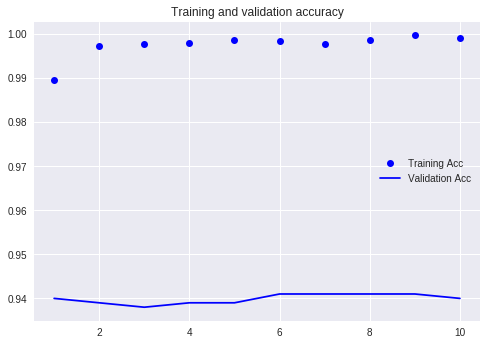

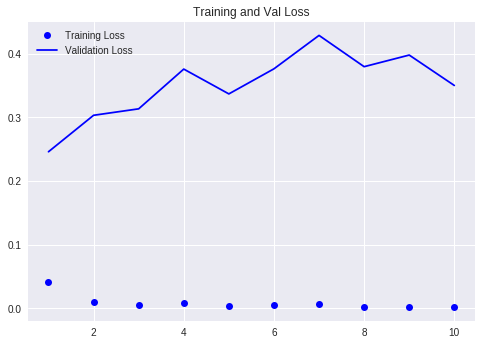

In [0]:
#####RUNS WITH FROZEN VGG16 CONV_BASE LAYER
import time
start=time.time()
history=model.fit_generator(train_generator,steps_per_epoch=100,epochs=30,validation_data=validation_generator,validation_steps=50)
end=time.time()
print("this takes {} minutes to run".format(np.int((end-start)/60)))


##PLOT THE ACCURACY AND LOSS
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training Acc')
plt.plot(epochs,val_acc,'b',label="Validation Acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label="Training Loss")
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title("Training and Val Loss")
plt.legend()

plt.show()

In [0]:
#####FINE TUNING MODEL.  LEAVE MOST OF THE PRETRAINED CONVOLUTION LAYER IN TACT EXCEPT FOR TOP LAYER

from keras import layers,models,optimizers
import time, numpy as np

model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='tanh'))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))


###UNFREEZES THE CONV_BASE BEFORE COMPILING
conv_base.trainable=True
set_trainable=False
for layer in conv_base.layers:
  if layer.name=='block5_conv1':
    set_trainable=True
  if set_trainable:
    layer.trainable=True
  else:
    layer.trainable=False
    

    
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-5),metrics=['acc'])

###RUNS CODE
start=time.time()
history=model.fit_generator(train_generator,steps_per_epoch=100,epochs=15,validation_data=validation_generator,validation_steps=50)
end=time.time()
print("this takes {} minutes to run".format(np.int((end-start)/60)))


Epoch 1/15
100/100 [==============================] - 59s 593ms/step - loss: 0.1194 - acc: 0.9700 - val_loss: 0.1713 - val_acc: 0.9304
Epoch 2/15
100/100 [==============================] - 55s 550ms/step - loss: 0.0426 - acc: 0.9870 - val_loss: 0.1932 - val_acc: 0.9318
Epoch 3/15
100/100 [==============================] - 53s 533ms/step - loss: 0.0321 - acc: 0.9883 - val_loss: 0.1805 - val_acc: 0.9397
Epoch 4/15
100/100 [==============================] - 54s 539ms/step - loss: 0.0343 - acc: 0.9870 - val_loss: 0.1679 - val_acc: 0.9399
Epoch 5/15
100/100 [==============================] - 54s 537ms/step - loss: 0.0268 - acc: 0.9898 - val_loss: 0.2257 - val_acc: 0.9295
Epoch 6/15
100/100 [==============================] - 54s 538ms/step - loss: 0.0291 - acc: 0.9893 - val_loss: 0.1891 - val_acc: 0.9412
Epoch 7/15
100/100 [==============================] - 54s 537ms/step - loss: 0.0170 - acc: 0.9940 - val_loss: 0.1760 - val_acc: 0.9418
Epoch 8/15
100/100 [==============================] - 5

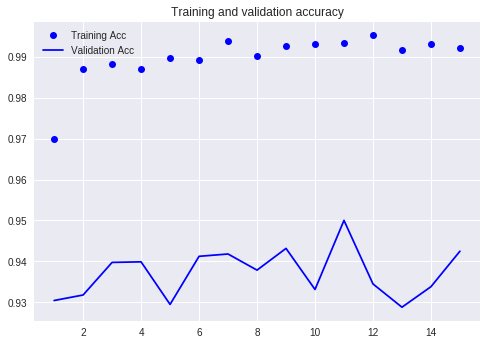

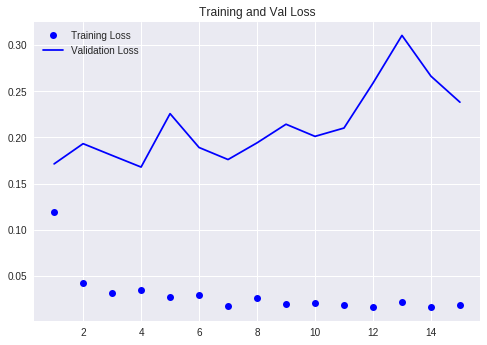

This took 13 minutes to run


In [0]:
###PLOTS ACCURACY AND LOSSES FROM THE HISTORY OF MODEL ABOVE
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training Acc')
plt.plot(epochs,val_acc,'b',label="Validation Acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label="Training Loss")
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title("Training and Val Loss")
plt.legend()

plt.show()
rt="This took {} minutes to run"

print(rt.format(np.int((start-end)/60)))

In [0]:

####CAN FINALLY EVALUATE THE MODEL ON THE TEST DATASET
test_generator=test_datagen.flow_from_directory(test_dir,target_size=(150,150),batch_size=20,class_mode='binary')
test_loss,test_acc=model.evaluate_generator(test_generator,steps=50)
print('test_acc:',np.round(test_acc,3))

Found 1000 images belonging to 2 classes.
test_acc: 0.942


In [0]:
model.save("catsanddogs.h5")
from google.colab import files
files.download("catsanddogs.h5")




In [0]:
new_model = models.load_model('catsanddogs.h5')
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_41 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 257       
Total params: 19,041,089
Trainable params: 11,405,825
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
####CREATE IMAGE TENSORS TO DEMONSTRATE EXAMPLES OF PREDICTIONS
img_path_c='/content/gdrive/My Drive/dogsandcats/test/cats/cat.1999.jpg'
img_path_d='/content/gdrive/My Drive/dogsandcats/test/dogs/dog.1999.jpg'
img_path_d2='/content/gdrive/My Drive/dogsandcats/test/dogs/dog.1686.jpg'
from keras.preprocessing import image
import numpy as np
img=image.load_img(img_path_c,target_size=(150,150))
img_tensor=image.img_to_array(img)
img_tensor=np.expand_dims(img_tensor,axis=0)
img_tensor/=255.

img_d=image.load_img(img_path_d,target_size=(150,150))
img_tensor_d=image.img_to_array(img_d)
img_tensor_d=np.expand_dims(img_tensor_d,axis=0)
img_tensor_d/=255.

img_d2=image.load_img(img_path_d2,target_size=(150,150))
img_tensor_d2=image.img_to_array(img_d2)
img_tensor_d2=np.expand_dims(img_tensor_d2,axis=0)
img_tensor_d2/=255.
print(img_tensor.shape)


(1, 150, 150, 3)


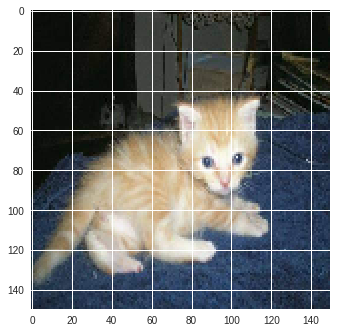

This is predicted to be a cat, with [0.82716] confidence


In [0]:
###PREDICTS CAT
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()
prediction=model.predict(img_tensor)
dic={0:'cat',1:'dog'}
conf="This is predicted to be a {}, with {} confidence"
animal=np.int(np.round(prediction))
if prediction>=.5:
  pred=np.round(prediction,5)
else:
  pred=np.round(1-prediction,5)
print(conf.format(dic[animal],pred[0]))

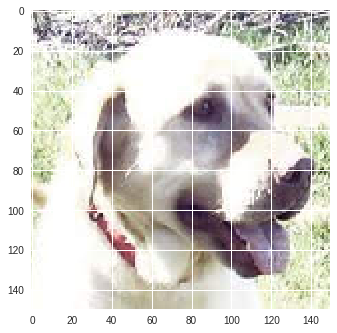

This is predicted to be a dog, with [0.66444] confidence


In [0]:
###PREDICTS DOG
import matplotlib.pyplot as plt
plt.imshow(img_tensor_d[0])
plt.show()
prediction=model.predict(img_tensor_d)
dic={0:'cat',1:'dog'}
conf="This is predicted to be a {}, with {} confidence"
animal=np.int(np.round(prediction))
if prediction>=.5:
  pred=np.round(prediction,5)
else:
  pred=np.round(1-prediction,5)
print(conf.format(dic[animal],pred[0]))

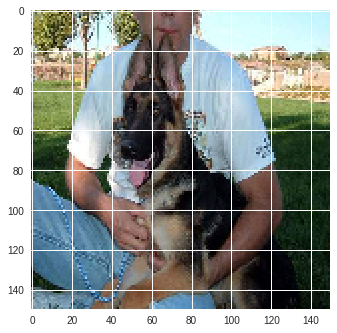

This is predicted to be a dog, with [0.79101] confidence


In [0]:
###PREDICTS DOG WITH HUMAN IN IT
import matplotlib.pyplot as plt
plt.imshow(img_tensor_d2[0])
plt.show()
prediction=model.predict(img_tensor_d2)
dic={0:'cat',1:'dog'}
conf="This is predicted to be a {}, with {} confidence"
animal=np.int(np.round(prediction))
if prediction>=.5:
  pred=np.round(prediction,5)
else:
  pred=np.round(1-prediction,5)
print(conf.format(dic[animal],pred[0]))

In [0]:
###PLAY AROUND WITH ANOTHER ARCHITECTURE THAT ADDS A DROPOUT LAYER
from keras import layers,models,optimizers
import time


    
model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='tanh'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

conv_base.trainable=True
set_trainable=False
for layer in conv_base.layers:
  if layer.name=='block5_conv1':
    set_trainable=True
  if set_trainable:
    layer.trainable=True
  else:
    layer.trainable=False
    
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-5),metrics=['acc'])

start=time.time()
history2=model.fit_generator(train_generator,steps_per_epoch=100,epochs=15,validation_data=validation_generator,validation_steps=70)
end=time.time()
print("this takes {} minutes to run".format(np.int((end-start)/60)))


Epoch 1/15
100/100 [==============================] - 62s 624ms/step - loss: 0.1271 - acc: 0.9685 - val_loss: 0.1727 - val_acc: 0.9311
Epoch 2/15
100/100 [==============================] - 57s 567ms/step - loss: 0.0397 - acc: 0.9860 - val_loss: 0.1767 - val_acc: 0.9393
Epoch 3/15
100/100 [==============================] - 57s 567ms/step - loss: 0.0309 - acc: 0.9895 - val_loss: 0.2304 - val_acc: 0.9306
Epoch 4/15
100/100 [==============================] - 57s 570ms/step - loss: 0.0212 - acc: 0.9928 - val_loss: 0.1745 - val_acc: 0.9432
Epoch 5/15
100/100 [==============================] - 57s 567ms/step - loss: 0.0258 - acc: 0.9913 - val_loss: 0.2352 - val_acc: 0.9306
Epoch 6/15
100/100 [==============================] - 57s 566ms/step - loss: 0.0215 - acc: 0.9928 - val_loss: 0.2088 - val_acc: 0.9408
Epoch 7/15
100/100 [==============================] - 57s 566ms/step - loss: 0.0151 - acc: 0.9953 - val_loss: 0.2848 - val_acc: 0.9316
Epoch 8/15
100/100 [==============================] - 5

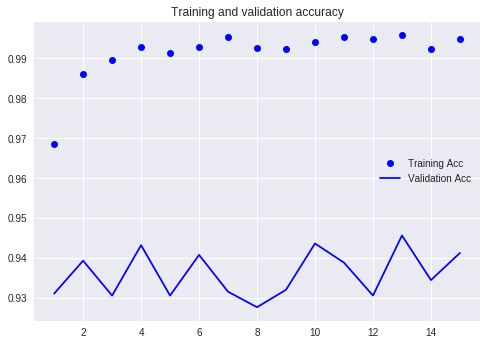

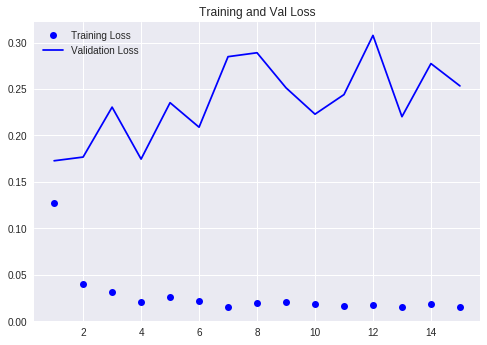

This took -14 minutes to run


In [0]:
acc=history2.history['acc']
val_acc=history2.history['val_acc']
loss=history2.history['loss']
val_loss=history2.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training Acc')
plt.plot(epochs,val_acc,'b',label="Validation Acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label="Training Loss")
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title("Training and Val Loss")
plt.legend()

plt.show()
rt="This took {} minutes to run"

print(rt.format(np.int((start-end)/60)))